In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import WhiteKernel, Matern

"""
https://archive.ics.uci.edu/ml/datasets/QSAR+aquatic+toxicity

1) TPSA(Tot)
2) SAacc
3) H-050
4) MLOGP
5) RDCHI
6) GATS1p
7) nN
8) C-040
9) quantitative response, LC50 [-LOG(mol/L)]

""";

In [2]:
from data_reader import data_reader

In [3]:
data = data_reader(42)

In [4]:
x, y = data.get_training()

In [5]:
x[:10].round(2), y[:10].round(2)

(array([[ 1.35,  1.74,  0.81,  0.03,  0.8 , -0.57,  0.03, -0.49],
        [ 0.15,  0.27, -0.62,  1.01,  1.5 ,  0.27, -0.75,  2.84],
        [ 0.9 ,  1.14,  0.81, -1.28,  0.39,  0.56,  0.82,  1.17],
        [-0.42, -0.92, -0.62,  0.89,  0.21, -0.93, -0.75, -0.49],
        [ 0.51,  0.6 ,  1.52, -1.52, -0.39, -0.34,  1.6 ,  1.17],
        [-0.14,  0.49,  0.81, -0.95, -1.04,  1.34, -0.75, -0.49],
        [-1.09, -0.92, -0.62, -0.39, -1.66, -1.14, -0.75, -0.49],
        [-0.65, -0.56, -0.62, -0.51, -0.42,  0.44, -0.75, -0.49],
        [-0.61, -0.22,  0.09,  0.74, -0.52, -1.68, -0.75, -0.49],
        [-0.78, -0.65, -0.62, -0.47, -0.54,  0.4 ,  0.03, -0.49]]),
 array([-0.18,  0.43, -1.43,  0.64, -0.41, -2.51, -0.74, -0.99,  0.91,
        -0.61]))

1.0000000000000002

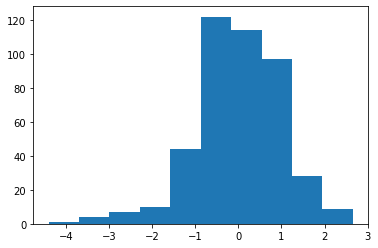

In [6]:
plt.hist(y)
np.std(y)

In [7]:
kernel = 1.**2 * Matern(length_scale=.1*np.ones(x.shape[1]),nu=2.0)\
            + 0.1**2 * WhiteKernel(noise_level=1.)

In [9]:
gpr = GaussianProcessRegressor(kernel=kernel,
                                  alpha=1e-5, 
                                  optimizer='fmin_l_bfgs_b', 
                                  n_restarts_optimizer=5, 
                                  normalize_y=False, 
                                  copy_X_train=True, 
                                  random_state=42)

In [10]:
gpr = gpr.fit(x, y)

In [11]:
gpr.log_marginal_likelihood_value_

-431.1456821158497

In [12]:
gpr.kernel_

0.968**2 * Matern(length_scale=[0.572, 1.48, 1.72, 1.79, 1.08, 2.74, 1.13, 0.1], nu=2) + 0.225**2 * WhiteKernel(noise_level=2.69)

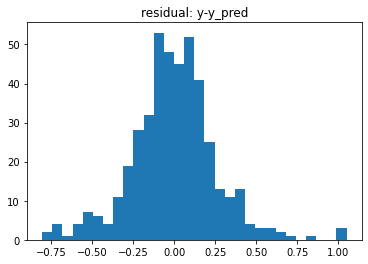

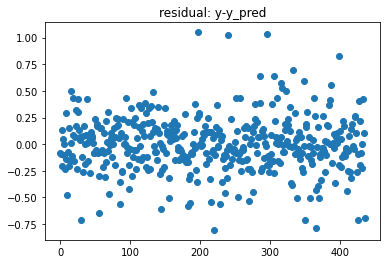

calculating percentages that are 1,2,3,&4 sigma away
sigma: 1 0.911
sigma: 2 0.991
sigma: 3 1.0
sigma: 4 1.0
coeff. of det. 0.9332838954186344


In [13]:
data.info(x,y,gpr)

In [14]:
x, y = data.get_test()

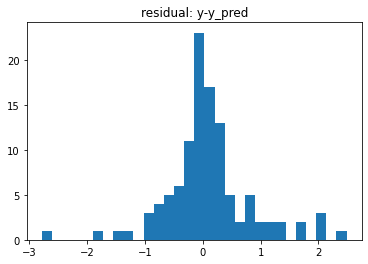

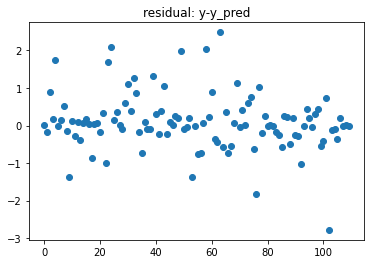

calculating percentages that are 1,2,3,&4 sigma away
sigma: 1 0.755
sigma: 2 0.918
sigma: 3 0.982
sigma: 4 0.991
coeff. of det. 0.5232944069878744


In [15]:
data.info(x,y,gpr)

In [16]:
np.save('data/sklearn_theta',gpr.kernel_.theta)